In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pydicom

In [2]:
import itk

In [3]:
PixelType = itk.ctype('float')

Dimension = 2
ImageType = itk.Image[PixelType, Dimension]

reader = itk.ImageFileReader[ImageType].New()

In [4]:
reader.SetFileName("/mnt/storage/Evidences/najara_issues/imagem1.dcm")
reader.Update()

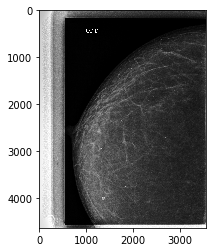

In [76]:
plt.imshow(itk.GetArrayFromImage(reader.GetOutput()), interpolation='nearest', cmap='gray')
plt.show()

In [96]:
np.amax(itk.GetArrayFromImage(reader.GetOutput()))

255.0

In [79]:
filter = itk.SobelEdgeDetectionImageFilter.New()

In [80]:
filter.SetInput(reader.GetOutput())

In [81]:
filter.Update()

In [14]:
#rescaler = itk.RescaleIntensityImageFilter().new(InputPrimary=filter.GetOutput())


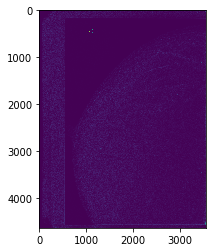

In [83]:
plt.imshow(itk.GetArrayFromImage(filter.GetOutput()), interpolation='nearest')
plt.show()


In [84]:
filter2= itk.ThresholdImageFilter.New(Input=filter.GetOutput())

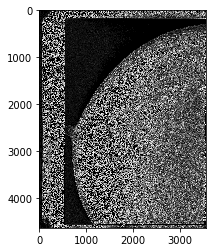

In [90]:
filter2.ThresholdAbove(50)
filter2.Update()
plt.imshow(itk.GetArrayFromImage(filter2.GetOutput()), interpolation='nearest', cmap='gray')
plt.show()

In [97]:
radiusValue=4
StructuringElementType = itk.FlatStructuringElement[2]
structuringElement = StructuringElementType.Ball(radiusValue)

dilation_filter = itk.GrayscaleDilateImageFilter[
    ImageType, ImageType, StructuringElementType].New()
dilation_filter.SetInput(filter2.GetOutput())
dilation_filter.SetKernel(structuringElement)

erosion_filter = itk.GrayscaleErodeImageFilter[
    ImageType, ImageType, StructuringElementType].New()
erosion_filter.SetInput(dilation_filter.GetOutput())
erosion_filter.SetKernel(structuringElement)

In [251]:
import cv2
import numpy as np

def quarterize_image(image):
    res = cv2.resize(image, dsize=(image.shape[1]//4, image.shape[0]//4), interpolation=cv2.INTER_CUBIC)
    return res

In [637]:
erosion_as_array = itk.GetArrayFromImage(erosion_filter.GetOutput())

reduzida = erosion_as_array#itk.GetImageFromArray(quarterize_image(erosion_as_array))
                            

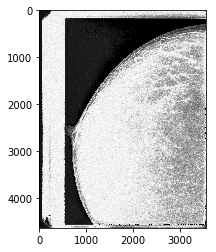

In [639]:
erosion_filter.Update()
plt.imshow(reduzida, interpolation='nearest', cmap='gray')
plt.show()

In [640]:
hough_transf = itk.HoughTransform2DLinesImageFilter.New()
#bola  =itk.HoughTransform2DLinesImageFilter.New()

In [643]:
hough_transf.SetInput(itk.GetImageFromArray(reduzida))
#hough_transf.SetNumberOfLines(3);
#hough_transf.SetVariance()
#hough_transf.SetNumberOfThreads(6)


In [230]:
#hough_transf.Update()

In [644]:
accumulator_image = hough_transf.GetOutput()


In [269]:
accumulator_image.Update()

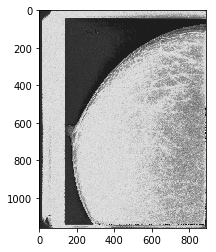

In [275]:
plt.imshow(itk.GetArrayFromImage(reduzida), interpolation='nearest', cmap='gray')
plt.show()

In [282]:
import cv2
import numpy as np

img = itk.GetArrayFromImage(reduzida)
gray = np.uint8(img)#cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,200)



In [517]:
import vectormath as vmath

In [539]:
bola = np.array([4,5,6])
bola.astype(float)
bola.dot(bola)

77

In [645]:
#img = itk.GetArrayFromImage(reader.GetOutput())
img= reduzida#itk.GetArrayFromImage(reduzida)
copy_to_paint = np.zeros(img.shape)
colored = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
edges = cv2.Canny(np.uint8(img),100,150,apertureSize = 3)
minLineLength = 40
maxLineGap = 40
lines = cv2.HoughLinesP(edges,1,np.pi/180,50,minLineLength,maxLineGap)

for x1,y1,x2,y2 in lines[:,0,:]:
        print("riscando..",x1,",",y1,"-->",x2,",",y2)
        cv2.line(colored,(x1,y1),(x2,y2),(0,255,0),5)
#plt.imshow(colored, interpolation='nearest')
#plt.show()
    


riscando.. 3553 , 1783 --> 3553 , 1742
riscando.. 3551 , 2986 --> 3551 , 2940
riscando.. 3550 , 3824 --> 3550 , 3783
riscando.. 3553 , 1690 --> 3553 , 1647
riscando.. 3551 , 3331 --> 3551 , 3255
riscando.. 558 , 836 --> 558 , 712
riscando.. 550 , 3396 --> 550 , 3299
riscando.. 557 , 1060 --> 557 , 838
riscando.. 3553 , 4056 --> 3553 , 3979
riscando.. 1041 , 1993 --> 1078 , 1931
riscando.. 3551 , 3772 --> 3551 , 3709
riscando.. 552 , 2355 --> 552 , 2283
riscando.. 556 , 1360 --> 556 , 1308
riscando.. 3553 , 1212 --> 3553 , 1170
riscando.. 1303 , 1593 --> 1346 , 1537
riscando.. 555 , 1781 --> 555 , 1741
riscando.. 553 , 1977 --> 553 , 1899
riscando.. 558 , 495 --> 558 , 411
riscando.. 550 , 2908 --> 550 , 2856
riscando.. 558 , 678 --> 558 , 638
riscando.. 556 , 1268 --> 556 , 1212
riscando.. 558 , 361 --> 558 , 408


In [593]:
class line_segment_in_image:
    
    def __init__(self,p1, p2,dimx,dimy):
        self.create(p1,p2)
        self.define_image_center_projection(dimx,dimy)
        
    def create(self, v1, v2):
        self.v1=v1
        #remember the stupid y,x order
        pte_normal = np.array([v1[1] - v2[1], 0 , v2[0] - v1[0]])
        self.normal= pte_normal // np.linalg.norm(pte_normal.astype(float))

    def projection(self, p1):
        vec1 = np.array([p1[0] - self.v1[0],0, p1[1] - self.v1[1]])
        d1 = self.normal.dot(vec1.astype(float))#.dot(self.normal)
        return d1
    
    def define_image_center_projection(self, image_width, image_height):
        center = np.array([image_height/2,image_width/2])
        self.center_proj = self.projection(center.astype(float))
        
    def same_side_as_image_center(self, p1):
        return  self.projection(p1) * self.center_proj > 0 
        
        




In [609]:
c_lines  = lines[:,0,:]
foca = [[(P[0],P[1]),(P[2],P[3])] for P in c_lines]
foca

[[(142, 1143), (257, 1143)],
 [(518, 43), (640, 43)],
 [(171, 42), (245, 42)],
 [(139, 241), (139, 129)],
 [(676, 44), (781, 44)]]

In [648]:
lines.shape
cropped_lines  = lines[:,0,:]
points = [[(P[0],P[1]),(P[2],P[3])] for P in c_lines]

line_segments = [line_segment_in_image(V[0],V[1],3560,4640) for V in points]
reduzida.shape

(4640, 3560)

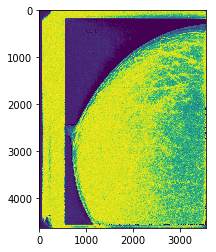

In [649]:
img=reduzida#itk.GetArrayFromImage(reduzida)
plt.imshow(img, interpolation= 'nearest')
plt.show()
for x in range (0,3560):
    for y in range (0,4640):
        for segment in line_segments:
            if False == segment.same_side_as_image_center([x,y]):
                img[y,x]=0
                continue



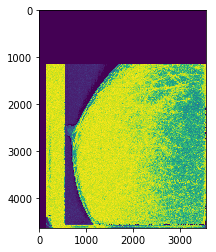

In [650]:
plt.imshow(img, interpolation= 'nearest')
plt.show()

In [633]:
import pydicom as dicom
teste22 = dicom.read_file("/mnt/storage/Evidences/najara_issues/imagem1.dcm")

In [634]:
learray = teste22.pixel_array

In [636]:
help(learray)

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


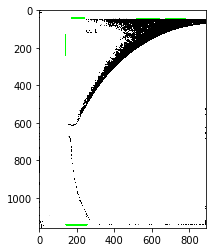

In [621]:

plt.imshow(colored, interpolation='nearest')
plt.show()

In [157]:
def sum_pixels_on_col(image, col):
    count =0
    slice = image[:,col]
    for p in slice:
        count = count +p
    return count

In [216]:
def sum_pixels_on_row(image, lin):
    count = 0
    slice = image[lin,:]
    for p in slice :
        count = count +p
    return count

In [201]:
range(7,3)

range(7, 3)

In [204]:
for x in range (3,7):
    print(x)

3
4
5
6


In [213]:
def clip_filled_image_horizontally(image, thold):
    relevant_dim = image.shape[1]
    histogram = np.zeros(relevant_dim)
    copy_of_image = image.copy()
    for x in range(0,relevant_dim) :
        histogram[x]=sum_pixels_on_col(image,x) // image.shape[0]
    last_col_left_to_right =0;
    for x in range( 0, image.shape[1]//2 ):
        if histogram[x] < thold:
            last_col_left_to_right = x;
    last_col_right_to_left =image.shape[1];
    for x in reversed(range(image.shape[1]//2, image.shape[1])):
        if histogram[x] < thold:
            last_col_right_to_left = x;
    for x in range( 0, last_col_left_to_right):
        copy_of_image[:,x]=0
    for x in reversed(range(last_col_right_to_left,image.shape[1])):
        copy_of_image[:,x]=0
    return copy_of_image
                    

In [214]:
def clip_filled_image_vertically(image, thold):
    relevant_dim = image.shape[0]
    histogram = np.zeros(relevant_dim)
    copy_of_image = image.copy()
    for x in range(0,relevant_dim) :
        histogram[x]=sum_pixels_on_row(image,x) // image.shape[1]
    last_row_left_to_right =0;
    for x in range( 0, image.shape[0]//2 ):
        if histogram[x] < thold:
            last_row_left_to_right = x;
    last_row_right_to_left =image.shape[0];
    for x in reversed(range(image.shape[0]//2, image.shape[0])):
        if histogram[x] < thold:
            last_row_right_to_left = x;
    for x in range( 0, last_row_left_to_right):
        copy_of_image[x,:]=0
    for x in reversed(range(last_row_right_to_left,image.shape[0])):
        copy_of_image[x,:]=0
    return copy_of_image

In [101]:
eroded_image_as_array = itk.GetArrayFromImage(erosion_filter.GetOutput())

In [221]:
teste0 = clip_filled_image_horizontally(eroded_image_as_array,8)
teste1 = clip_filled_image_vertically(teste0,2)

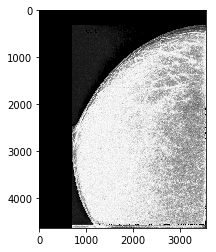

In [222]:
plt.imshow(teste1, interpolation='nearest', cmap='gray')
plt.show()

#hough transform?


In [ ]:
plt.imshow(itk.GetArrayFromImage(scaled_image), interpolation='nearest', cmap='gray')
plt.show()

In [ ]:
#playground

In [174]:
histogram = np.zeros(eroded_image_as_array.shape[1])

In [175]:
for x in range(0,eroded_image_as_array.shape[1]) :
    histogram[x]=sum_pixels_on_col(eroded_image_as_array,x)

In [176]:
for x  in range(0, eroded_image_as_array.shape[1]):
    histogram[x] = histogram[x] / eroded_image_as_array.shape[1]

In [172]:
histogram


array([0., 0., 0., ..., 0., 0., 0.])

In [151]:
import matplotlib.pyplot as plt

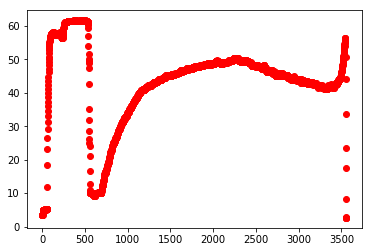

In [177]:
plt.plot(range(0,eroded_image_as_array.shape[1]), histogram, 'ro')

plt.show()

In [165]:
sum_of_all_col = 0
for x in range(0,eroded_image_as_array.shape[1]):
    sum_of_all_col = histogram[x] + sum_of_all_col

In [166]:
sum_of_all_col


154059.6430715065

In [195]:
copy_of_eroded = eroded_image_as_array.copy()

In [198]:
last_col_in_first_half_too_poor =0;
for x in range( 0, eroded_image_as_array.shape[1]//2 ):
        if histogram[x] < 10:
            last_col_in_first_half_too_poor = x;

In [199]:
last_col_in_first_half_too_poor


682

In [196]:
for x in range( 0, last_col_in_first_half_too_poor):
    copy_of_eroded[:,x]=0

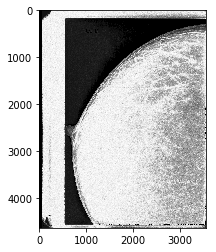

In [197]:
plt.imshow(copy_of_eroded, interpolation='nearest', cmap='gray')
plt.show()